In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
# import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

## Генерация и подготовка данных

In [3]:
x = np.random.uniform(-10, 10, 20000)
y = np.random.uniform(-10, 10, 20000)
z = np.sin(x + 2 * y) * np.exp(-(2 * x + y)**2)

In [4]:
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
z_tensor = torch.from_numpy(z).float()

In [5]:
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    x_tensor, y_tensor, z_tensor,
    test_size=0.30, 
    random_state=RANDOM_SEED
    )

x_test, x_val, y_test, y_val, z_test, z_val = train_test_split(
    x_test, y_test, z_test,
    test_size=0.50, 
    random_state=RANDOM_SEED
    )

x_train.shape, y_train.shape, z_train.shape, \
x_test.shape, y_test.shape, z_test.shape, \
x_val.shape, y_val.shape, z_val.shape

(torch.Size([14000]),
 torch.Size([14000]),
 torch.Size([14000]),
 torch.Size([3000]),
 torch.Size([3000]),
 torch.Size([3000]),
 torch.Size([3000]),
 torch.Size([3000]),
 torch.Size([3000]))

## Инициация

In [6]:
class Approx(torch.nn.Module):
    def __init__(self):
        super(Approx, self).__init__()
        self.fc1 = torch.nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x, y):
        x = torch.cat((x.unsqueeze(1), y.unsqueeze(1)), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Обучение

In [7]:
model = Approx()

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    z_train_pred = model(x_train, y_train)
    
    test_loss = loss_func(z_train_pred, z_train.unsqueeze(1))
    test_loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {test_loss.item():.4f}')

Epoch 100/1000, Train Loss: 0.0166
Epoch 200/1000, Train Loss: 0.0155
Epoch 300/1000, Train Loss: 0.0146
Epoch 400/1000, Train Loss: 0.0137
Epoch 500/1000, Train Loss: 0.0129
Epoch 600/1000, Train Loss: 0.0122
Epoch 700/1000, Train Loss: 0.0116
Epoch 800/1000, Train Loss: 0.0113
Epoch 900/1000, Train Loss: 0.0107
Epoch 1000/1000, Train Loss: 0.0102


## Валидация

In [8]:
model.eval()
with torch.no_grad():
    val_output = model(x_val, y_val)
    val_loss = loss_func(val_output, z_val.unsqueeze(1))
    print(f'Validation Loss: {val_loss.item():.4f}')

Validation Loss: 0.0108


## Тестирование

In [9]:
with torch.no_grad():
    z_test_pred = model(x_test, y_test)
    test_loss = loss_func(z_test_pred, z_test.unsqueeze(1))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0092


## Визуализация

150 точек для визуализации:

In [10]:
X, Y = x_test, y_test
X = X[::20]
Y = Y[::20]
X, Y = np.meshgrid(X, Y)

Z = np.sin(X + 2 * Y) * np.exp(-(2 * X + Y)**2)

z_test_pred = z_test_pred[::20]

Y.shape, X.shape, Z.shape, z_test_pred.shape

((150, 150), (150, 150), (150, 150), torch.Size([150, 1]))

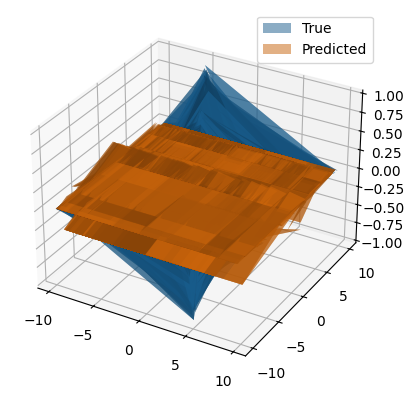

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, label='True', alpha=0.5)
ax.plot_surface(X, Y, z_test_pred, label='Predicted', alpha=0.5)

ax.legend()

plt.show()